# Bayesian Flow Networks: Continous Data case of studies.

Autor: Claudio Canales D.

# Continuous data



For continous data $\ x=\mathbb{R}$ we got that $\mathbf{x} \in \mathbb{R}^D$. $\mathbf{x}$ is normalised to lie in $\left[-1,1 \right]^D$ to ensure that the networks inputs remain in a reasonable range. **(This is not a requirement for the method and it is only used as a standard normalisation in ML)**

## Input distribution

The input distribution for continuous data is a diagonal normal:

$$
\begin{aligned}
\boldsymbol{\theta} & \stackrel{\text { def }}{=}\{\boldsymbol{\mu}, \rho\} \\
p_I(\mathbf{x} \mid \boldsymbol{\theta}) & \stackrel{\text { def }}{=} \mathcal{N}\left(\mathbf{x} \mid \boldsymbol{\mu}, \rho^{-1} \boldsymbol{I}\right),
\end{aligned}
$$

where $\mathbf{I}$ is a $D \times D$ identity matrix. The prior is defined by parameters:

$$ \mathbf{\theta_{0}}\stackrel{\text { def }}{=}\{\boldsymbol{0}, 1\} $$

where $\boldsymbol{0}$ is a $D$ dimensional vectors of zeros. Therefore, the input prior is a standar mutivariate normal:

$$ p_I(\mathbf{x} \mid \boldsymbol{\theta})  \stackrel{\text { def }}{=} \mathcal{N}\left(\boldsymbol{0} \mid \boldsymbol{\mu},  \boldsymbol{I}\right) $$

**(All it matters is that thethe priorencodes the information received by x) **. This comonent is not used to make predictions.

## Bayesian Update
Given  univariate Gaussian prior $\mathcal{N}(\mu_a, \rho_a^{-1}) $ over unkown data $x$ it can be shown that the bayesian posterior after observing a noisy sample y from a normal distribution $\mathcal{N}(x, \alpha^{-1}) $ with known precission $\alpha$ is $\mathcal{N}(\mu_b,\rho_b^-1)$, where:

$$\rho_b = \rho_a+\alpha $$
$$\mu_b = \frac{\mu_a \rho_a+ y\alpha}{\rho_b} $$

Since both input and sender distributions, $p_I(\mathbf{x \mid \theta})$ and $p_S(\mathbf{y \mid x;\alpha})$ are normal with diagonal covariance, the previus equation can be applied to obtain the following Bayesian update function o parameters $\mathbf{\theta}_{i-1}=\{ \mathbf{\mu_{i-1}},\rho_{i-1}\}$ and sender sample $\mathbf{y}$ drawn from $p_S(\mathbf{y \mid x}; \alpha \mathbf{I})=\mathcal{N}(\mathbf{x}, \alpha \mathbf{I})$:

$$ h(\{ \mathbf{\mu}_{i-1}, \rho_{i-1} \}, \mathbf{y},\alpha)=    \{ \mathbf{\mu_i}, \rho_i \} $$

with

$$\rho_i = \rho_{i-1}+\alpha $$
$$\mu_i = \frac{\mathbf{\mu_{i-1}} \rho_{i-1} + \mathbf{y} \alpha }{\rho_i} $$

### Example

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import torch.nn as nn

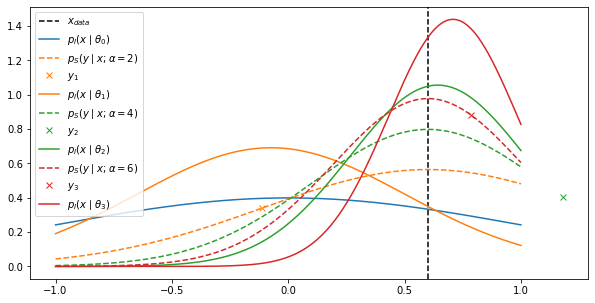

<Figure size 432x288 with 0 Axes>

In [80]:
def bayessian_update_1d(mu, rho, y, alpha):
    """Applies the 1D Bayessian update to the data

    Args:
        mu float: mean
        rho float: accuracy of input distribution
        y float: sample of sender
        alpha float: accuracy

    Return:
    (mean, accuracy)
    """
    return (rho+alpha, (mu*rho+alpha*y)/(rho+alpha))

# Univariate Data
x_data = 0.6

# Initial prior distribution
mu, rho = (0,1) # Mean 0, std=1

# accuracy
acc = 2

x_domain = np.linspace(- 1, 1, 4000)

plt.figure(figsize=(10, 5))

plt.axvline(x = x_data, color = "k", label = r'$x_{data}$',linestyle="--")

# Initial Prior
p_i = stats.norm.pdf(x_domain, mu, 1/rho)
plt.plot(x_domain, p_i, color=f"C{0}", label=fr"$p_I(x \mid \theta_{0})$")

for update in range(1,4):
    # Sample from sender
    y = np.random.normal(loc=x_data, scale=(1/acc)**0.5)
    # Sender distribution
    p_s = stats.norm.pdf(x_domain, x_data, (1/acc)**0.5)
    # Bayesian update
    rho, mu = bayessian_update_1d(mu, rho, y, acc)
    # Input distribution updated
    p_i = stats.norm.pdf(x_domain, mu, (1/rho)**0.5)
    # Plot
    plt.plot(x_domain, p_s, color=f"C{update}", label=fr"$p_S(y \mid x;\alpha={acc})$", linestyle="--")
    plt.plot(y, stats.norm.pdf(y, x_data, (1/acc)**0.5), color=f"C{update}",marker="x", label=f"$y_{update}$", linestyle="")
    plt.plot(x_domain, p_i, color=f"C{update}", label=fr"$p_I(x \mid \theta_{update})$")
    # Linear accuracy update
    acc += 2

plt.legend()
plt.show()
plt.savefig("Bayesian_updates.pdf",dpi=300)


## Bayesian Update  Distribution

The bayesian update can be calculated by calculating the distribution of $\mathbf{\mu}_i $ which is the only random part of $\mathbf{\theta}_i$. This can be derived from the bayessian update:

$$
p_U\left(\boldsymbol{\theta}_i \mid \boldsymbol{\theta}_{i-1}, \mathbf{x} ; \alpha\right)=\mathcal{N}\left(\boldsymbol{\mu}_i \mid \frac{\alpha \mathbf{x}+\boldsymbol{\mu}_{i-1} \rho_{i-1}}{\rho_i}, \frac{\alpha}{\rho_i^2} \boldsymbol{I}\right)
$$

## Accuracy Scheduler $\beta(t)$

For continuous data the accuracy scheduler $\beta(t)$ is designed to ensure a constant information flow into the input distribution. From this analysis it is obtained that:

$$ \alpha(t) = -\frac{2\ln \sigma_1}{\sigma_1^{2t}}$$
$$\beta(t)=\int_{t'=0}^{t} \alpha(t')dt' $$

## Bayesian flow distribution

By takng into consideration that the accuraccies are additive, it is possible to generalize the bayesian update to continuous time, given by:


$$P_F(\mathbf{\theta}\mid\mathbf{x};t)=P_U(\cdot \mid \mathbf{\theta,x};\beta(t))=\sigma_1^{-2t}-1 $$

As we know the accuracy scheduler, it is possible to derive the bayesian flow distribution as:

$$P_F(\mathbf{\theta} \mid \mathbf{x};t) =\mathcal{N}(\mathbf{\mu} \mid \frac{\beta(t)}{1+\beta(t)}\mathbf{x},\frac{\beta(t)}{(1+\beta(t)^2} \mathbf{I}) $$



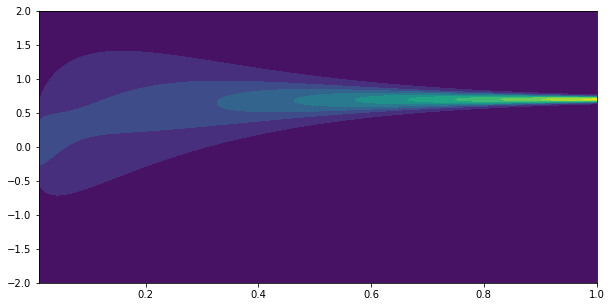

In [14]:
from matplotlib.colors import LogNorm

nx, ny = (300, 300)
t = np.linspace(0.01, 1, nx)
d_x = np.linspace(-2, 2, ny)
mx, my = np.meshgrid(t, d_x)

sigma = 0.02
x_data = 0.7


z = np.zeros(mx.shape)
samples = np.zeros((4, ny))
mu = 0
for i in range(len(mx)):
    beta = sigma**(-2*t[i])-1
    mu = beta/(1+beta)*x_data
    std = beta/((1+beta)**2)
    z[:, i] = np.log(stats.norm.pdf(d_x, mu, std**0.5)+2)
    

plt.figure(figsize=(10, 5))
plt.contourf(mx,my,z,levels=10)

## Output Distribution

Following standard practice for diffusion models, the output distribution is defined by reparameterising a prediction of the Gaussian noise vector $\epsilon \sim \mathcal{N} (0, I)$ used to generate the mean $\mu$ passed as input to the network. The full derivation of the distribution is in the paper, and it is defined as:


$$ \mathbf{x} = \frac{\mathbf{\mu}}{\gamma(t)} - \sqrt{ \frac{1-\gamma(t)}{\gamma(t)} \mathbf{\epsilon}} $$

$$ \mathbf{\hat{x}}(\mathbf{\theta},t) = \frac{\mathbf{\mu}}{\gamma(t)} - \sqrt{ \frac{1-\gamma(t)}{\gamma(t)} \hat{\mathbf{\epsilon}}} $$

$$P_O(\mathbf{x}\mid \mathbf{\theta};t) = \delta(\mathbf{x}- \mathbf{\hat{x}}(\mathbf{\theta},t)) $$

## Sender distribution.

The sender distribution of the continous data is modeled as a normal with with precision $\alpha$.

$$P_S(\mathbf{y} \mid \mathbf{x};\alpha) = \mathcal{N}(\mathbf{x} \mid \alpha^{-1}I) $$

## Receiver Distribution.

The receiver distribution is obtained by marginalizing by $\mathbf{\hat{y}}$.

$$P_R(\mathbf{y} \mid \mathbf{\theta};t,\alpha) = \mathcal{N}(\mathbf{y} \mid \mathbf{\hat{x}}, \alpha^{-1}I) $$

## Continuos Time Loss.

The original publication explains all the details of the continous time loss function. The continous loss function is calculated by:

$$L^{\infty}(\mathbf{x})=-\ln \sigma_1 \mathbb{E}_{t \sim U(0,1), P_F(\mathbf{\theta} \mid \mathbf{x};t) }  \frac{||\mathbf{x}-\mathbf{\hat{x}}(\mathbf{\theta},t) ||^2}{\sigma_1^{2t}}$$

# Examples of continous time Bayesian Flow Networks.

1. Mixture of Gaussians
2. MNIST - Continous

## 1. Bayes Flow Network: Mixture of Gaussian 2D.

### Dataset (Mixture of Gaussians)

In [15]:
def gaussian_mixture_dataset(batch_size=10000, device="cpu"):
    samp = batch_size//4
    N = batch_size
    X = np.random.randn(N, 2).astype('float32')*0.05
    X[:samp, :] += [0.1, 0.1]
    X[samp:samp*2, :] += [-0.1, 0.1]
    X[samp*2:samp*3, :] += [-0.1, -0.1]
    X[samp*3:, :] += [0.1, -0.1]

    return torch.tensor(X, device=device, requires_grad=False)

### General purpose MLP as a NN for Bayesian Flow Network.

In [16]:
class MLPBFS(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=[32, 64, 32]):
        super(MLPBFS, self).__init__()
        layers = []
        for i, h in enumerate(hidden_dim):
            if i==0:
                layers.append(nn.Sequential(
                    nn.Linear(input_dim + 1, h),
                    nn.SiLU()))
            else:
                layers.append((nn.Sequential(
                    nn.Linear(hidden_dim[i-1], h),
                    nn.SiLU())))

        layers.append(nn.Linear(hidden_dim[-1], output_dim))
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x_hat = torch.cat((x, t), dim=-1)
        return self.mlp(x_hat).view(x.shape)

## Continous Bayessian Flow Network Class.

In [65]:
class ContinuousBayesianFlow:
    def __init__ (self,model, input_dim=2 , beta: float= None, sigma: float=0.01, lr=1e-3, device="cuda"):

        self.device = device

        self.input_dim = input_dim

        self.model = model.to(device)
        self.beta = beta
        self.sigma = sigma
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        self.logs = {}

    def get_beta(self, t):
        return self.beta * (t ** 2.0)

    def get_gamma(self, t):
        return 1 - (self.sigma ** (t * 2.0))

    def get_alpha(self, t):
        return self.beta * t

    def continuous_output_prediction(self, mu, t, gamma, x_min=-1, x_max=1, t_min=1e-10):
        output_nn = self.model(mu, t)
        x_hat = (mu / gamma) - torch.sqrt((1 - gamma) / gamma) * output_nn
        x_hat = torch.clip(x_hat, x_min, x_max)
        condition = t < t_min
        return torch.where(t < t_min, torch.zeros_like(x_hat), x_hat)


    def continuous_loss(self, target):

        target = target.to(self.device)

        batch_size = target.shape[0]

        t = torch.clip(torch.rand((batch_size, 1), requires_grad=False, device=self.device, dtype=torch.float32), 1e-6, 1)

        gamma = self.get_gamma(t)

        eps = torch.randn_like(target).to(self.device)

        mu = gamma*target + (gamma * (1 - gamma)).sqrt()*eps

        x_hat = self.continuous_output_prediction(mu, t, gamma)

        weights = -np.log(self.sigma) / (self.sigma ** (t * 2.0)+1e-6)
        
        l2_norm = ((target - x_hat) ** 2)

        loss = weights * l2_norm

        return loss.mean()

    def sample(self, batch_size=64, updates = 100):
        self.model.eval()
        mu = torch.zeros((batch_size, self.input_dim), device=self.device, dtype=torch.float32)
        rho = 1.
        sigma = self.sigma
        n = updates
        for i in range(1,updates+1):
            t = (i-1)/n*torch.ones((batch_size, 1), device=self.device, dtype=torch.float32)
            x_hat = self.continuous_output_prediction(mu, t, self.get_gamma(t))
            alpha = sigma**(-2*(i/updates))*(1-sigma**(2/updates))

            y = x_hat + torch.randn_like(x_hat)*(torch.full_like(x_hat, fill_value=(1 / alpha))).sqrt()

            mu = ((rho * mu) + (alpha * y)) / (rho + alpha)
            rho = rho + alpha

        t = torch.ones((batch_size, 1), device=self.device, dtype=torch.float32)
        x_hat = self.continuous_output_prediction(mu, t, self.get_gamma(t))

        return x_hat

    def train_custom_dataloader(self, dataloader=gaussian_mixture_dataset, steps=5000, batch_size=10000):
        self.logs["loss"] = []
        self.logs["step"] = []
        for step in range(steps):
            self.model.zero_grad()
            x = dataloader(batch_size=batch_size, device="cuda")
            loss = self.continuous_loss(x)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)
            self.optimizer.step()
            self.logs["loss"].append(loss.item())
            self.logs["step"].append(step)

    def train(self, dataloader, epochs=200):
        self.logs["loss"] = []
        self.logs["step"] = []
        step = 0
        for epoch in range(epochs):
            for _ in dataloader:
                self.model.zero_grad()
                x, _ = t
                x = x.to(self.device).reshape(-1, self.input_dim)
                loss = self.continuous_loss(x)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)
                self.optimizer.step()
                step += 1

                # logs
                self.logs["loss"].append(loss.item())
                self.logs["step"].append(step)

### Training:
1. $\sigma_1 = 0.008$
2. Epochs:5000
3. Batch size: 10000
4. lr=1-e3
5. Optimizer: Adam
6. Mlp: [3, 64, 64, 64, 64, 2]

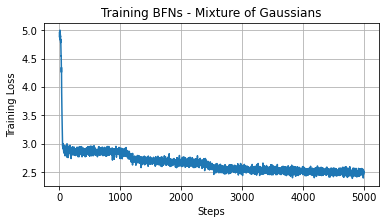

In [66]:
model = MLPBFS(2, 2, hidden_dim=[64, 64, 64, 64])
bayesian_flow = ContinuousBayesianFlow(model, sigma=0.008)
bayesian_flow.train_custom_dataloader()
logs = bayesian_flow.logs

plt.figure(figsize=(6, 3))
plt.xlabel("Steps")
plt.ylabel("Training Loss")
plt.title("Training BFNs - Mixture of Gaussians")
plt.plot(logs["loss"])

plt.grid()
plt.savefig("training_gm_bfn.pdf", dpi=300)

<Figure size 432x288 with 0 Axes>

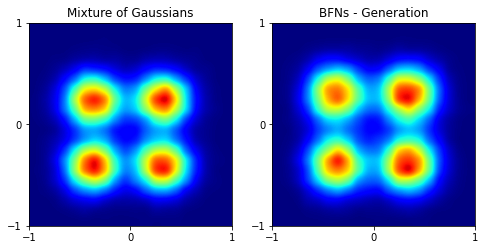

In [19]:
# Distribution of mixture of Gaussians.
x_gm = gaussian_mixture_dataset(batch_size=40000).detach().cpu().numpy()

# Generated distribution with BFNs
x_bfn = bayesian_flow.sample(batch_size=40000, updates=100).detach().cpu().numpy()

h_gm, x, y, p = plt.hist2d(x_gm[:, 0], x_gm[:, 1], bins=(20, 20), density=True)
h_bfn, x, y, p = plt.hist2d(x_bfn[:, 0], x_bfn[:, 1], bins=(20, 20), density=True)
plt.clf()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 4))
pcm1 = ax1.imshow(h_gm, origin = "lower", interpolation = "gaussian", extent=[-1,1,-1,1], cmap="jet")
pcm2 = ax2.imshow(h_bfn, origin = "lower", interpolation = "gaussian", extent=[-1,1,-1,1], cmap="jet")

ax1.title.set_text('Mixture of Gaussians')
ax1.axes.xaxis.set_ticks([-1,0,1])
ax1.axes.yaxis.set_ticks([-1,0,1])
ax2.title.set_text('BFNs - Generation')
ax2.axes.xaxis.set_ticks([-1,0,1])
ax2.axes.yaxis.set_ticks([-1,0,1])

plt.savefig("BFNs_generation.pdf", dpi=300)


## MNIST - Example.

### Dataset.

In [56]:
import torchvision
import torchvision.transforms as transforms

# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to [-1, 1]
    #transforms.Lambda(lambda x: torch.round((x + 1) / 2).to(torch.int64)) # Discretize data
])


# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Training:
1. $\sigma_1 = 0.02$
2. Epochs:200
3. Batch size: 256
4. lr=1-e3
5. Optimizer: Adam
6. Mlp: [785, 256, 128, 64, 128, 256, 784]

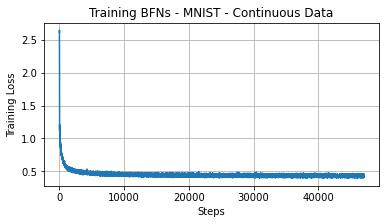

In [70]:
dim_mnist = 28*28

model = MLPBFS(dim_mnist, dim_mnist, hidden_dim=[256, 128, 64, 128, 256])
bayesian_flow = ContinuousBayesianFlow(model, input_dim=dim_mnist, sigma=0.02, lr=1e-3)

bayesian_flow.train(train_loader, epochs=200)
logs = bayesian_flow.logs

plt.figure(figsize=(6, 3))
plt.xlabel("Steps")
plt.ylabel("Training Loss")
plt.title("Training BFNs - MNIST - Continuous Data")
plt.plot(logs["loss"])

plt.grid()
plt.savefig("training_mnist_bfn.pdf", dpi=300)

In [74]:
from torchvision.utils import make_grid
def show_tensor_images(x, num_images=64, save=False):
    image_tensor = x.reshape(num_images, 1, 28, 28)
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=8)
    
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.tight_layout()
    if save:
        plt.savefig("generated_mnist.pdf", dpi=300)
    plt.show()

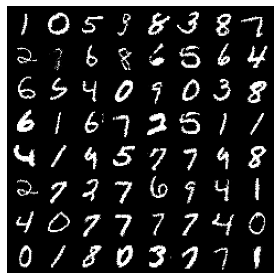

In [78]:
x = bayesian_flow.sample(batch_size=64, updates=500)
show_tensor_images(x, save=True)